In [1]:
import kagglehub

path = kagglehub.dataset_download("wkirgsn/electric-motor-temperature")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-motor-temperature


In [2]:
import shutil
import os

print("Đường dẫn gốc của dataset:", path)

new_dir = "/content/dataset"

os.makedirs(new_dir, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(new_dir, filename)
    if os.path.isfile(src_file):
        shutil.copy(src_file, dst_file)

print("Dataset đã được sao chép đến:", new_dir)


Đường dẫn gốc của dataset: /kaggle/input/electric-motor-temperature
Dataset đã được sao chép đến: /content/dataset


In [3]:
import pandas as pd

df = pd.read_csv("/content/dataset/measures_v2.csv")
k = df[df['profile_id'] == 17]
k

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15959,131.232086,18.098608,49.645897,-6.513609,43.098316,4999.946777,-97.676331,0.980545,51.822525,33.403080,24.637297,-0.421235,17
15960,131.169312,18.090189,49.578072,-6.500326,43.102539,4999.945312,-97.792351,0.953651,51.827511,33.396442,24.680479,-0.393254,17
15961,131.102997,18.089109,49.575481,-6.498843,43.100647,4999.947266,-97.791840,0.931305,51.831402,33.393707,24.715746,-0.389909,17
15962,131.055298,18.089380,49.606102,-6.476041,43.087551,4999.944336,-97.793709,0.903135,51.829365,33.398624,24.741184,-0.399254,17


In [4]:
import numpy as np
data = np.array(k, dtype = np.float32)[::, :12]
print(data.shape)
data

(15964, 12)


array([[ -0.4506815 ,  18.805172  ,  19.08667   , ...,  18.316547  ,
         19.85069   ,   0.1871008 ],
       [ -0.325737  ,  18.818571  ,  19.09239   , ...,  18.314955  ,
         19.850672  ,   0.24541749],
       [ -0.44086403,  18.82877   ,  19.08938   , ...,  18.326307  ,
         19.850657  ,   0.17661534],
       ...,
       [131.103     ,  18.08911   ,  49.57548   , ...,  33.393707  ,
         24.715746  ,  -0.38990855],
       [131.0553    ,  18.08938   ,  49.606102  , ...,  33.398624  ,
         24.741184  ,  -0.39925414],
       [130.85103   ,  18.105665  ,  49.625244  , ...,  33.386982  ,
         24.74348   ,  -0.4537872 ]], dtype=float32)

In [41]:
class Kalman:
  def __init__(self, x, dt = 0.5):
    x = np.array(x).reshape(-1, 1)
    self.dims = x.shape[0]
    self.x = np.concatenate((x, np.zeros(x.shape)), axis = 0)

    self.f = np.eye(2 * self.dims)
    for i in range(self.dims):
      self.f[i, i + self.dims] = dt
    '''
    self.q = 0.5 * np.eye(2 * self.dims)
    for i in range(2 * self.dims):
      for j in range(2 * self.dims):
        self.q[i, j] *= dt ** (i + j + 1) / ( i + j + 1)
    '''
    self.q = np.eye(2 * self.dims) * 0.1
    self.p = np.eye(2 * self.dims) * 1000

    self.h = np.zeros((self.dims, 2 * self.dims), dtype= np.float32)
    for i in range(self.dims):
      self.h[i, i] = 1

    self.r = 0.005

  def predict(self):
    self.x = self.f @ self.x + np.random.multivariate_normal(mean=np.zeros(2 * self.dims), cov = self.q).reshape(-1, 1)
    self.p = self.f @ self.p @ self.f.T + self.q

  def correct(self, x):
    x = x.reshape(-1, 1)

    self.k = self.p @ self.h.T @ np.linalg.pinv(self.h @ self.p @ self.h.T + self.r)

    self.x = self.x + self.k @ (x - self.h @ self.x)

    self.p = (np.eye(2 * self.dims) - self.k @ self.h) @ self.p

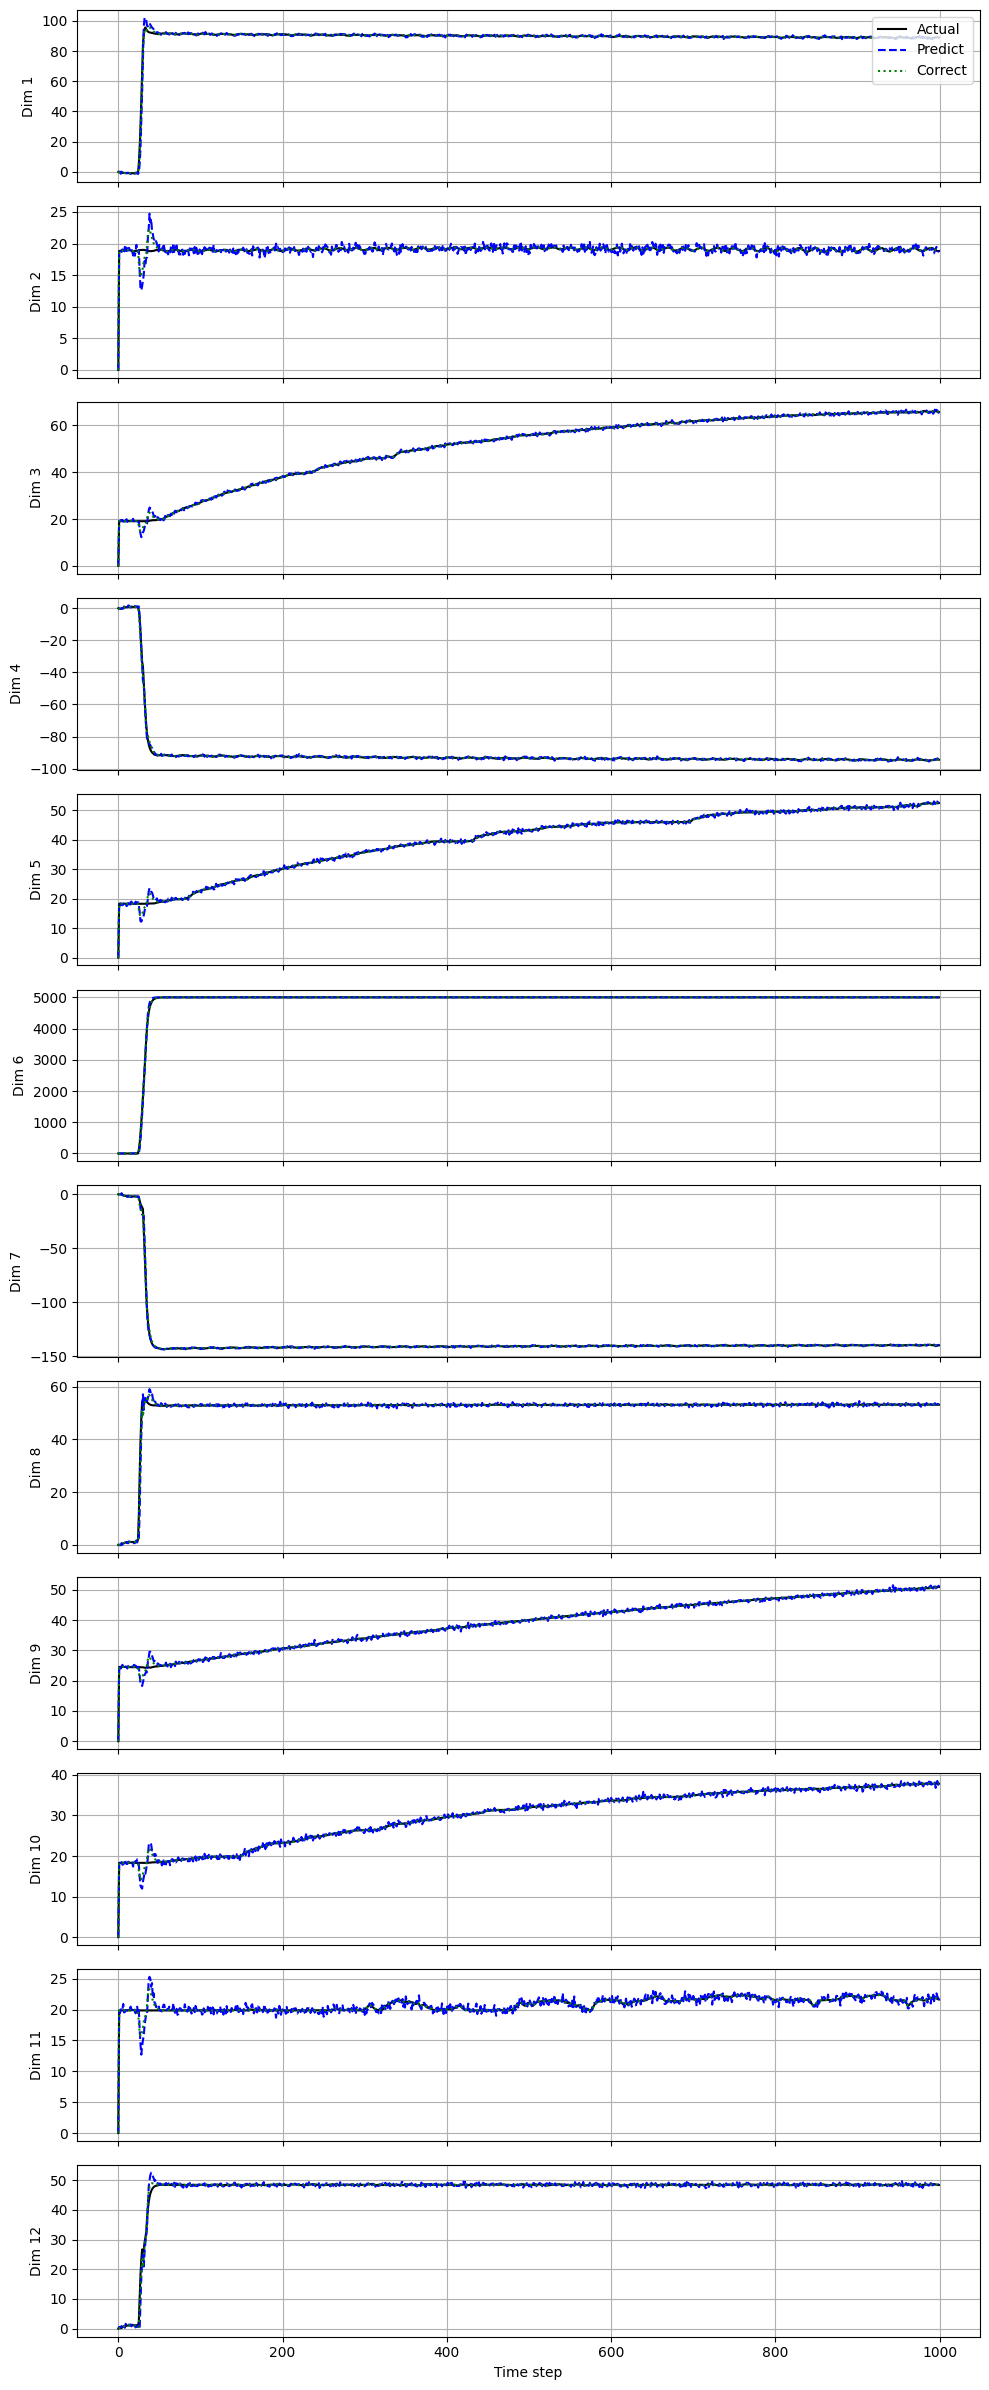

In [42]:
import matplotlib.pyplot as plt
import numpy as np

time_steps = 1000
dims = 12
A = Kalman(data[0])

actual_all = np.zeros((time_steps, dims))
predict_all = np.zeros((time_steps, dims))
correct_all = np.zeros((time_steps, dims))

for i in range(1, time_steps):
    actual = data[i].copy()
    A.predict()
    predict = A.x.copy().flatten()
    A.correct(data[i].reshape(dims, 1))
    correct = A.x.copy().flatten()

    actual_all[i] = actual
    predict_all[i] = predict[:dims]
    correct_all[i] = correct[:dims]

fig, axs = plt.subplots(dims, 1, figsize=(10, 2*dims), sharex=True)

for d in range(dims):
    axs[d].plot(range(time_steps), actual_all[:, d], label='Actual', color='black')
    axs[d].plot(range(time_steps), predict_all[:, d], label='Predict', color='blue', linestyle='--')
    axs[d].plot(range(time_steps), correct_all[:, d], label='Correct', color='green', linestyle=':')
    axs[d].set_ylabel(f'Dim {d+1}')
    axs[d].grid(True)
    if d == 0:
        axs[d].legend(loc='upper right')

axs[-1].set_xlabel('Time step')
plt.tight_layout()
plt.show()
